# Generating prime portraits
Last week I learned about the existance of prime portraits. Unfortunatly I could not find the code, and I loved to see the same portraits in color. 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import skimage.transform
import skimage.io
import numpy as np
from sklearn.cluster import KMeans
import random
from PIL import Image
from PIL import ImageFont

import scipy.misc
from PIL import ImageDraw 

## Testing for primality
When working with extremely long primes the naive method won't work anymore. Instead we take a probabilistic approach to the prime numbers. 

In [3]:

def try_composite(a, d, n, s):
    # test the base a to see whether it is a witness for the compositeness of n
    if pow(a, d, n) == 1:
        return False
    for i in range(s):
        if pow(a, 2**i * d, n) == n-1:
            return False
    return True # n is definitely composite

    
def is_probable_prime(n, mrpt_num_trials = 5):
    """
    Miller-Rabin primality test.
 
    A return value of False means n is certainly not prime. A return value of
    True means n is very likely a prime.

    """
    assert n >= 2
    # special case 2
    if n == 2:
        return True
    # ensure n is odd
    if n % 2 == 0:
        return False
    # write n-1 as 2**s * d
    # repeatedly try to divide n-1 by 2
    s = 0
    d = n-1
    while True:
        quotient, remainder = divmod(d, 2)
        if remainder == 1:
            break
        s += 1
        d = quotient
    assert(2**s * d == n-1)
                                     
    for i in range(mrpt_num_trials):
        a = random.randrange(2, n)
        if try_composite(a, d, n, s):
            return False
        
    return True # no base tested showed n as composite

assert is_probable_prime(2)
assert is_probable_prime(3)
assert not is_probable_prime(4)
assert  is_probable_prime(5)
assert not is_probable_prime(123456789)
primes_under_1000 = [i for i in range(2, 1000) if is_probable_prime(i)]
assert len(primes_under_1000) == 168
assert primes_under_1000[-10:] == [937, 941, 947, 953, 967, 971, 977, 983, 991, 997]
assert is_probable_prime(6438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)
assert not is_probable_prime(7438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)


## Generating the images
The basis of the algorithm is generating images with only 10 possible color values. Although I did not know what a common approach to this is I opted for applying a k-means algorithm on a reshaped image (so each pixel is a point in 3D speace) and using the 10 created clusters as color values. 

Important for the prime generation is that you ad a little bit of noise to the original image to create images that look the same, but actually are a different number (a new chance for a prime number!). 

In [4]:
def get_k_means(image):
    pointcloud = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=10).fit(pointcloud)
    return kmeans

def create_numbered_image(image, kmeans):
    """
    Turns an RGB image into an image with the labels of clusters of the supplied kmeans classifier. 
    """
    # apply noise
    stdev = np.std(image)
    random_noise = np.random.random_sample(size=image.shape)*(stdev/3)
    image = image + random_noise
    
    orig_shape = image.shape
    image = np.reshape(image, (-1, 3))

    numbered_image = kmeans.predict(image)
    numbered_image = np.reshape(numbered_image, orig_shape[:2])
    
    assert numbered_image.shape[0] < 50 and "WATCH OUT FOR THE HEIGHT OF IMAGES"
    assert numbered_image.shape[1] < 50 and "WATCH OUT FOR THE WIDTH OF IMAGES"
    
    # make sure the end is uneven
    if numbered_image[-1,-1]%2==0:
        numbered_image[-1,-1] += 1

    return numbered_image

def numbered_image_to_normal_image(numbered_image, kmeans):
    """
    Turns an image with only values between 0 and 9 into a colored image by using the cluster centers 
    of the supplied kmeans classifier. 
    """
    shape = (numbered_image.shape[0], numbered_image.shape[1], 3)
    image = np.zeros(shape)
    for label, color in zip(range(10), kmeans.cluster_centers_):
        image[numbered_image==label] = color
    return image


## Examples

Let's look at a few examples. As you can see each image is slightly different. 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


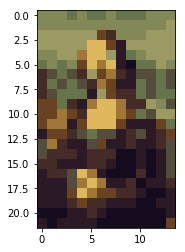

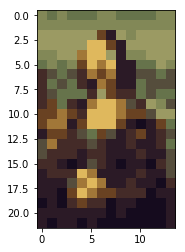

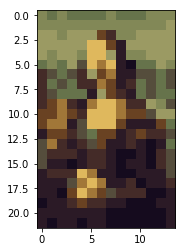

In [5]:

def load_and_resize_image(filename, resize_factor=18):
    image = skimage.io.imread(filename)
    image = image.astype(np.float64)
    image = image / 255.
    
    oldshape = image.shape
    resized_image = skimage.transform.resize(image, (oldshape[0]//resize_factor, oldshape[1]//resize_factor))

    return resized_image

resized_image = load_and_resize_image('input_pictures/monalisa.jpg')
kmeans = get_k_means(resized_image)
for _ in range(3):
    n_image = create_numbered_image(resized_image, kmeans)
    normal_image = numbered_image_to_normal_image(n_image, kmeans)
    
    plt.imshow(normal_image)
    plt.show()

In [6]:
def image_to_number(numbered_image):
    to_be_number = numbered_image.reshape(-1)
    as_string = ''.join([str(int(x)) for x in to_be_number])
    as_int = int(as_string)
    return as_int, as_string


def show_and_save_image(image, n_image, filename, fontsize=16):
    oldshape = image.shape
    resized_image= scipy.misc.imresize(image,(oldshape[0]*fontsize, oldshape[1]*fontsize), interp='nearest')
    img = Image.fromarray(resized_image).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt)
    font = ImageFont.truetype("pirulen rg.ttf", fontsize)
    for y_i, totype in enumerate(n_image):
        for x_i, letter in enumerate(totype):
            xpos = x_i * fontsize + 1
            ypos = y_i * fontsize
            if letter == 1:
                xpos += 4
            draw.text((xpos, ypos),str(letter),(255,255,255, 128),font=font)
    img = Image.alpha_composite(img, txt)    

    img.save(filename)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

def result_filename(filename):
    return filename.split('.')[0] + "-prime.png"

In [7]:


def is_good_prime_portrait(n_image):
    integer, string = image_to_number(n_image)
    
    if is_probable_prime(integer): 
        return integer, string, n_image
    else:
        return None

In [8]:
def print_result(string, n_image):
    print(string)
    print("-"*100)
    for line in n_image:
        print(''.join([str(x) for x in line]))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working with size (21, 16, 3)
555551110751351155511115207115115555077900711555555522750209111518877708554701158869507700370988576680708276077058858578977800055553700160758855558847735008485555597870070918555555300847000555555598077001555555555177781135555598500008390755555910888400915555535988178551118884483808388448888488131104848888884481338488888844448484484889
----------------------------------------------------------------------------------------------------
5555511107513511
5551111520711511
5555077900711555
5555227502091115
1887770855470115
8869507700370988
5766807082760770
5885857897780005
5553700160758855
5588477350084855
5559787007091855
5555300847000555
5555980770015555
5555517778113555
5598500008390755
5559108884009155
5553598817855111
8884483808388448
8884881311048488
8888448133848888
8844448484484889


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


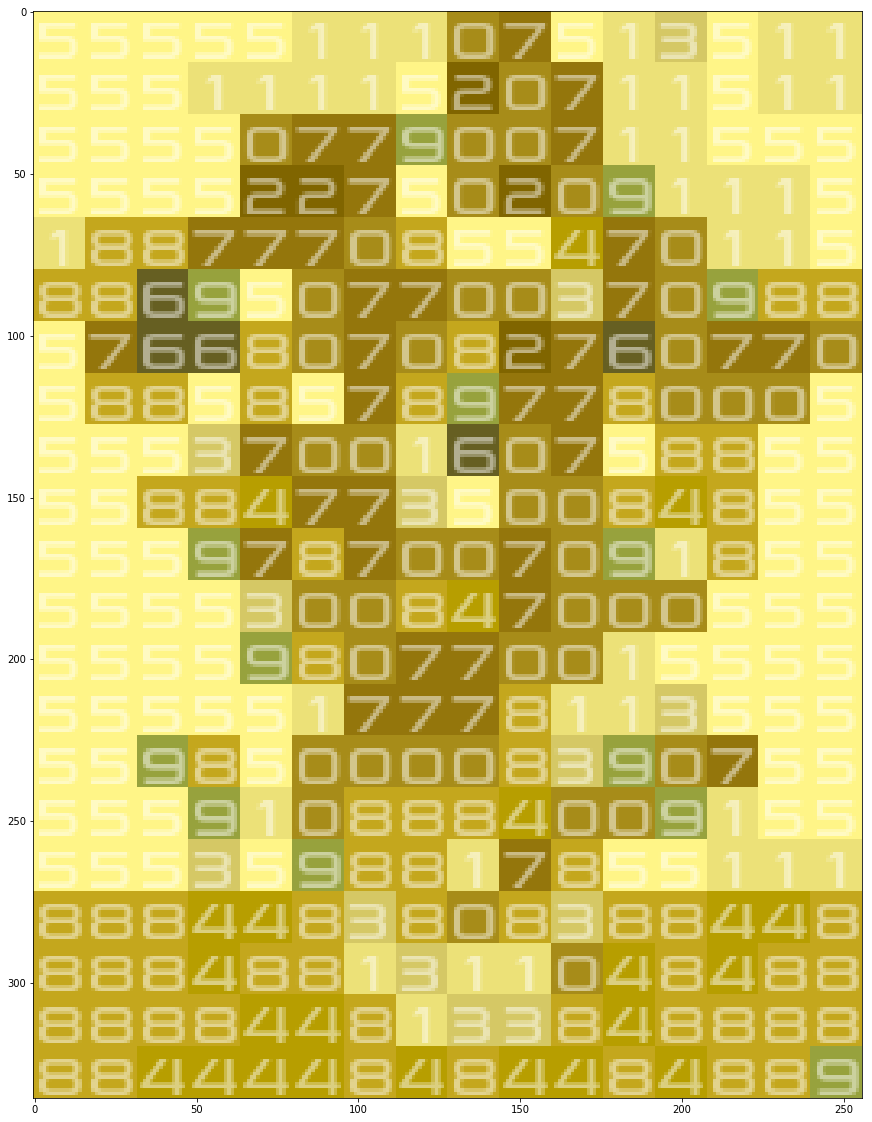

In [9]:
folder = 'input_pictures/'

filenames = [
     folder + 'sunflowers.jpg',
]

for filename in filenames:
    resized_image = load_and_resize_image(filename)
    print("Working with size " + str(resized_image.shape))

    kmeans = get_k_means(resized_image)
    
    for _ in range(10000):
        n_image = create_numbered_image(resized_image, kmeans)    
        
        result = is_good_prime_portrait(n_image)
        if result != None:
            integer, string, n_image = result
            print_result(string, n_image)
            
            normal_image = numbered_image_to_normal_image(n_image, kmeans)
            show_and_save_image(normal_image, n_image, result_filename(filename))
            
            break

## Multi threaded attempt


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working with size (23, 18, 3)
Time spent in (function name) is 0.15383600000000008 time per result: 0.015383600000000008
Time spent in (function name) is 0.1676479999999998 time per result: 0.00838239999999999
Time spent in (function name) is 0.1825480000000006 time per result: 0.006084933333333353
Time spent in (function name) is 0.1956319999999998 time per result: 0.0048907999999999955
Time spent in (function name) is 0.21189200000000064 time per result: 0.004237840000000013
Time spent in (function name) is 0.22802100000000003 time per result: 0.0038003500000000005
Time spent in (function name) is 0.2446040000000007 time per result: 0.003494342857142867
Time spent in (function name) is 0.26000900000000016 time per result: 0.003250112500000002
Time spent in (function name) is 0.2766959999999994 time per result: 0.003074399999999993
Time spent in (function name) is 0.2922799999999999 time per result: 0.002922799999999999
Time spent in (function name) is 0.3085269999999998 time per resu

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


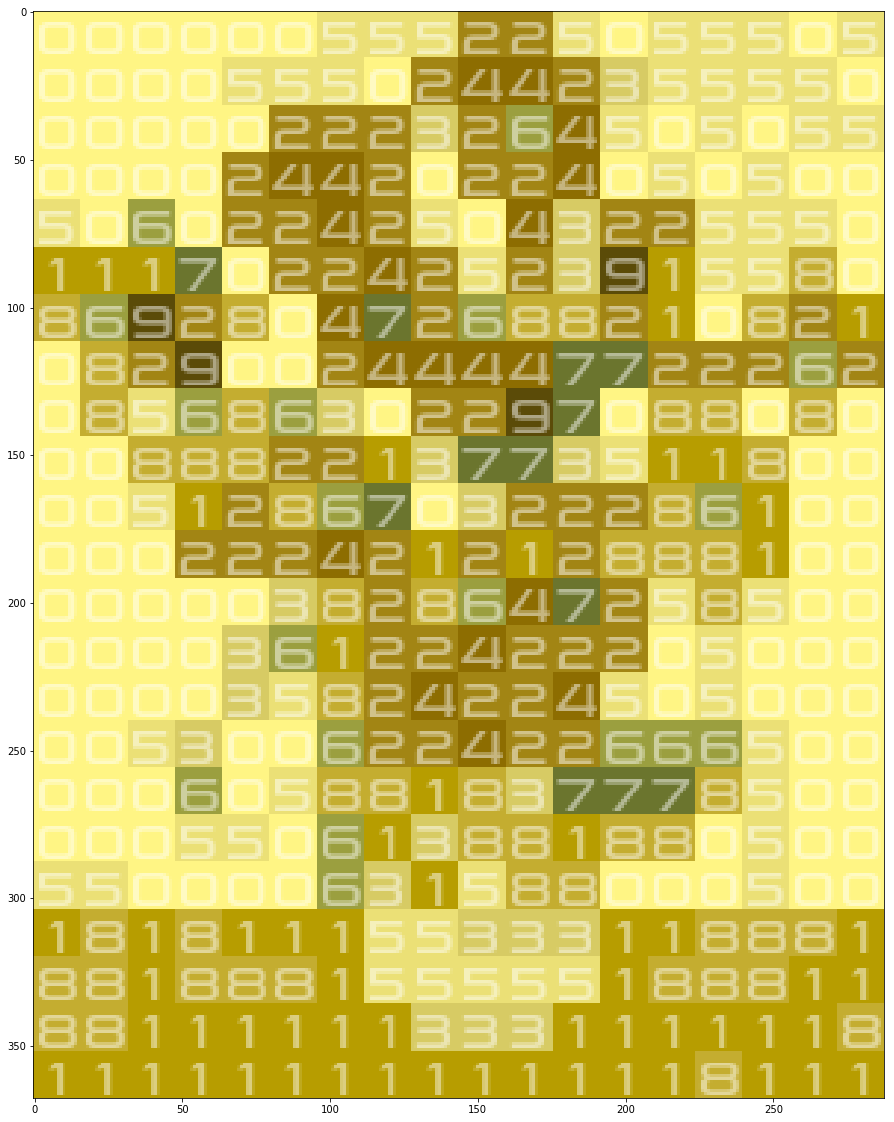

In [10]:
#from multiprocessing.dummy import Pool as ThreadPool 
from multiprocessing import Pool as ThreadPool 
import time

pool = ThreadPool(4) 
start = time.clock() 

resized_image = load_and_resize_image(filenames[0], resize_factor=16)
print("Working with size " + str(resized_image.shape))

kmeans = get_k_means(resized_image)
image_generator = (create_numbered_image(resized_image, kmeans) for _ in range(100000))

results = pool.imap_unordered(is_good_prime_portrait, image_generator)
total_results = 0
for result in results:
    total_results += 1
    if total_results%10==0:
        elapsed = time.clock()
        elapsed = elapsed - start
        print("Time spent in (function name) is {} time per result: {}".format(str(elapsed), str(elapsed/total_results)))
        
    if result != None:
        integer, string, n_image = result
        print_result(string, n_image)

        normal_image = numbered_image_to_normal_image(n_image, kmeans)
        show_and_save_image(normal_image, n_image, result_filename(filename))

        break


In [ ]:
pool.terminate()

In [ ]:
pool.close()

## How does this scale

Appartenlty the largest known prime number is 22338618 long (http://primes.utm.edu/largest.html). This would allow us to create a 4726 * 4726 prime portrait, which means that prime portraits in 4K resolution are viable :D



In [ ]:
def trials_needed_img(w,h):
    return 2.3*w*h

needed = [trials_needed_img(x,x) for x in range(1,300)]
plt.plot(needed)

## Can we create a prime movie? 
The Solitude of Prime Numbers - Wikipedia